In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import os
import pandas as pd

from load_data import BiopsyDataset, BiopsyKeepScaleDataset, DATA_DIR, TRANSFORMS, P53_CLASS_NAMES
from resnet import ResNetModel, ResNetModelDoubleBinary
from _resnet_patch import ResNetModelDoubleBinary as ResNetModelDoubleBinaryPatch

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print("Device: {}".format(device))


Device: cuda
Device: cuda


In [2]:
img_size = 1024
transform_arg = "basic_normalize"

train_transform = TRANSFORMS[transform_arg]
test_transform = None
if "normalize" in transform_arg:
    test_transform = TRANSFORMS["normalize"]

# Load the datasets
test_dataset = BiopsyDataset(root_dir=DATA_DIR, class_names=P53_CLASS_NAMES,
    size=img_size, labels_filename="test", transform=test_transform)
print("Test dataset size: ", len(test_dataset))
# train_dataset = BiopsyDataset(root_dir=DATA_DIR, class_names=P53_CLASS_NAMES,
#     size=img_size, labels_filename="train", transform=train_transform,
#     data_limit=None)
# print("Train dataset size: ", len(train_dataset))

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1)

train_transform_ks = TRANSFORMS['rotation_grey_normalize']
test_dataset_ks = BiopsyKeepScaleDataset(root_dir=DATA_DIR, class_names=P53_CLASS_NAMES,
    size=img_size, labels_filename="test", transform=test_transform, size_limit=4096, fill_bg=0.5)
print("Test dataset (keep scale) size: ", len(test_dataset_ks))
test_loader_ks = torch.utils.data.DataLoader(test_dataset_ks, batch_size=1)

Class distribution:  {'Wildtype': 15, 'Overexpression': 15, 'Nullmutation': 15, 'Doubleclone': 15}
Loaded images from file
Test dataset size:  60
Class distribution:  {'Wildtype': 13, 'Overexpression': 13, 'Nullmutation': 14, 'Doubleclone': 15}
Processing images


100%|██████████| 55/55 [00:10<00:00,  5.07it/s]

Test dataset (keep scale) size:  55


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


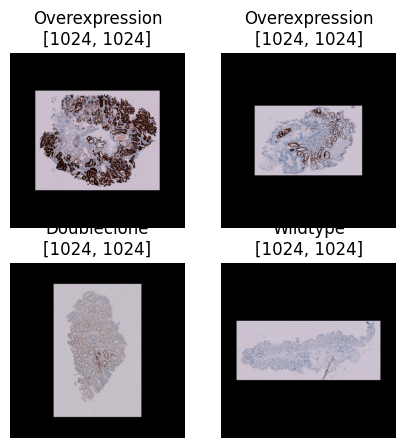

In [3]:
test_dataset_ks.plot_example_grid(2, figsize=(5, 5))

# Load models

In [5]:
# checkpoint_path = "models/resnet_resize-epoch14-acc0.70.ckpt"
checkpoint_path = "models/(old)/resnet_s1024-epoch31-acc0.69.ckpt"
model = ResNetModel.load_from_checkpoint(checkpoint_path, num_classes=len(P53_CLASS_NAMES))
model.eval()

# The non-augmented models seems to have better heatmaps
checkpoint_path_db = "models/acc0.72_epoch44_s1024_end-to-end_double-binary.ckpt"   # 77 on test set, 76 on bolero
checkpoint_path_db = "models/acc0.67_epoch39_s1024_end-to-end_double-binary.ckpt" # best on test set (80), 83 on bolero, 87 with .1,.1
# checkpoint_path_db = "models/acc0.69_epoch39_s1024_end-to-end_double-binary.ckpt" # more robust (augmented) model (81 on test, 85 on bolero)
# checkpoint_path_db = "models/acc0.66_epoch37_s1024_end-to-end_double-binary.ckpt" # more robust (augmented) model (83 on test, 80 on bolero, 87 with .15,.15)
model_db = ResNetModelDoubleBinary.load_from_checkpoint(checkpoint_path_db)
model_db.eval()

# keep-scale model, with grey padding
checkpoint_path_ks = "models/acc0.73_epoch46_s1024_end-to-end_double-binary_ks.ckpt" # Before fixing wandb test, 80+ on test, 80 on bolero (with eagerness for nullmut)
checkpoint_path_ks = "models/acc0.72_epoch41_s1024_end-to-end_double-binary_ks.ckpt" # 87 on test, 87 on bolero
model_ks = ResNetModelDoubleBinary.load_from_checkpoint(checkpoint_path_ks)
model_ks.eval()

# patch model
checkpoint_path_patch = "models/acc0.72_epoch22_end-to-end_double-binary.ckpt" # 
model_patch = ResNetModelDoubleBinaryPatch.load_from_checkpoint(checkpoint_path_patch)
model_patch.eval()
pass

MODEL: ResNetModel
MODEL ARGS: num_classes=4, latents_path=None, rotation_invariant=True, lr=0.001, weight_decay=0.0005, lr_step_size=30, lr_gamma=0.1
MODEL: ResNetModel
MODEL ARGS: num_classes=4, latents_path=None, rotation_invariant=True, lr=0.001, weight_decay=0.0005, lr_step_size=30, lr_gamma=0.1
SUBMODEL: ResNetModelDoubleBinary
MODEL ARGS: see_opposite_class_data=normal
MODEL: ResNetModel
MODEL ARGS: num_classes=4, latents_path=None, rotation_invariant=True, lr=0.001, weight_decay=0.0005, lr_step_size=30, lr_gamma=0.1
SUBMODEL: ResNetModelDoubleBinary
MODEL ARGS: see_opposite_class_data=normal
MODEL: ResNetModel
MODEL ARGS: num_classes=4, lr=0.001, weight_decay=0.0005, lr_step_size=30, lr_gamma=0.1
SUBMODEL: ResNetModelDoubleBinary
MODEL ARGS: see_opposite_class_data=no_loss


In [6]:
from clam_model.use_clam import load_clam_model, clam_predict, process_image
retccl, clam_model = load_clam_model(device)
clam_model.outputs = {}

# Run models on test

In [7]:
# Test the model with the test dataloader
for mdl in [model, model_db]:
    mdl.outputs['test'] = []
    mdl = mdl.to(device)
    for i, batch in tqdm(enumerate(test_loader)):

        with torch.no_grad():
            batch[0] = batch[0].to(device)
            batch[1] = batch[1].to(device)
            mdl.test_step(batch, i)

        # Clear the cache
        torch.cuda.empty_cache()
    print("Accuracy: ", np.mean([1 if o['preds'] == o['labels'] else 0 for o in mdl.outputs['test']]))

# # Test the model with the test dataloader (keep scale)
# for mdl in [model_ks]:
#     mdl.outputs['test'] = []
#     mdl = mdl.to(device)
#     for i, row in tqdm(enumerate(test_dataset.labels)):
#         idx = row[0]
#         label = torch.tensor(row[1]).to(device).unsqueeze(0)
#         img = plt.imread(os.path.join(DATA_DIR, "biopsies", f"{idx}.png"))
#         img = cv2.resize(img, (img.shape[1]//4, img.shape[0]//4))
#         img = test_dataset_ks.transform(torch.tensor(img)).to(device).unsqueeze(0).permute(0, 3, 1, 2)

#         with torch.no_grad():
#             mdl.test_step((img, label), i)

#         # Clear the cache
#         torch.cuda.empty_cache()
#     print("Accuracy: ", np.mean([1 if o['preds'] == o['labels'] else 0 for o in mdl.outputs['test']]))

# Test the patch model
# model_patch.outputs['test'] = []
# model_patch = model_patch.to(device)
# for i, row in tqdm(enumerate(test_dataset.labels), total=len(test_dataset.labels)):
#     idx = row[0]
#     label = torch.tensor(row[1]).to(device).unsqueeze(0)
#     img = plt.imread(os.path.join(DATA_DIR, "biopsies", f"{idx}.png")) # shape (h, w, 3)
#     pred, presence_probs, patch_scores = model_patch.predict_biopsy(torch.tensor(img).permute(2,0,1).float(), patch_size=256)
#     model_patch.outputs['test'].append({"preds": pred, "labels": label.item(), "presence_probs": presence_probs, "patch_scores": patch_scores})

#     # Clear the cache
#     torch.cuda.empty_cache()
# print("Accuracy: ", np.mean([1 if o['preds'] == o['labels'] else 0 for o in model_patch.outputs['test']]))


# Test the CLAM model
# clam_model.outputs['test'] = []
# clam_model = clam_model.to(device)
# for i, row in tqdm(enumerate(test_dataset.labels)):
#     idx = row[0]
#     label = torch.tensor(row[1]).to(device).unsqueeze(0)
#     img = plt.imread(os.path.join(DATA_DIR, "biopsies", f"{idx}.png")) # shape (h, w, 3)
#     pred, class_probs, patch_attention = clam_predict(retccl, clam_model, torch.tensor(img).permute(2, 0, 1).float())
#     clam_model.outputs['test'].append({"preds": pred, "labels": label.item(), "class_probs": class_probs, "patch_attention": patch_attention})

#     # Clear the cache
#     torch.cuda.empty_cache()
# print("Accuracy: ", np.mean([1 if o['preds'] == o['labels'] else 0 for o in clam_model.outputs['test']]))
# 0.7166666666666667

60it [00:02, 28.07it/s]


Accuracy:  0.6833333333333333


60it [00:01, 36.31it/s]

Accuracy:  0.8


# Visualize heatmap for CLAM

-8.2615 20.505087


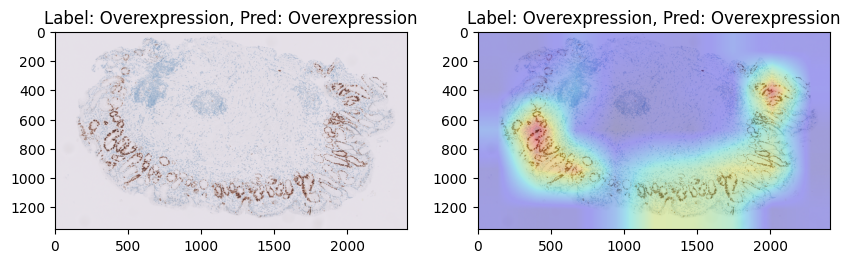

In [8]:
import json
with open("../CLAM/results/test_s1/clam_outputs.json", "r") as f:
    clam_outputs = json.load(f)

non_empty_patch_indices_by_biopsy = torch.load(os.path.join(DATA_DIR, "non_empty_patch_indices_gs256_relaxed.pt"))

test_idx = 19
output = clam_outputs[test_idx]
label = output['labels']
pred = output['preds']
class_probs = output['class_probs']
patch_attention = output['patch_attention']

idx = test_dataset.labels[test_idx][0]
img = plt.imread(os.path.join(DATA_DIR, "biopsies", f"{idx}.png")) # shape (h, w, 3)
patch_size = 256
# _, non_empty_indices = process_image(torch.tensor(img).permute(2,0,1), patch_size)
non_empty_indices = non_empty_patch_indices_by_biopsy[idx]
patch_rows = max(round(img.shape[0] / patch_size), 1)
patch_cols = max(round(img.shape[1] / patch_size), 1)
# The patch attention is a 1D array and corresponds to the non-empty indices
all_patch_attention = torch.zeros(patch_rows * patch_cols)
all_patch_attention[non_empty_indices] = torch.tensor(patch_attention)
all_patch_attention = all_patch_attention.reshape(patch_rows, patch_cols)
heatmap = cv2.resize(all_patch_attention.numpy(), (img.shape[1], img.shape[0]))
print(heatmap.min(), heatmap.max())
# heatmap = torch.nn.functional.sigmoid(torch.tensor(heatmap-heatmap.min())/10).numpy()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img)
ax[0].set_title(f"Label: {P53_CLASS_NAMES[label]}, Pred: {P53_CLASS_NAMES[pred]}")

if label == 2:
    mask = plt.imread(os.path.join(DATA_DIR, "masks", f"{idx}.png"))
    # Draw black contour on the img
    contours, _ = cv2.findContours((mask > 0).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(img, contours, -1, (0, 0, 0), 5)

ax[1].imshow(img)
ax[1].imshow(heatmap, alpha=0.3, cmap='jet'
            #  , vmin=5, vmax=10
             )
ax[1].set_title(f"Label: {P53_CLASS_NAMES[label]}, Pred: {P53_CLASS_NAMES[pred]}")

plt.show()

# Visualize indivdual predictions for test

Accuracy:  0.8166666666666667


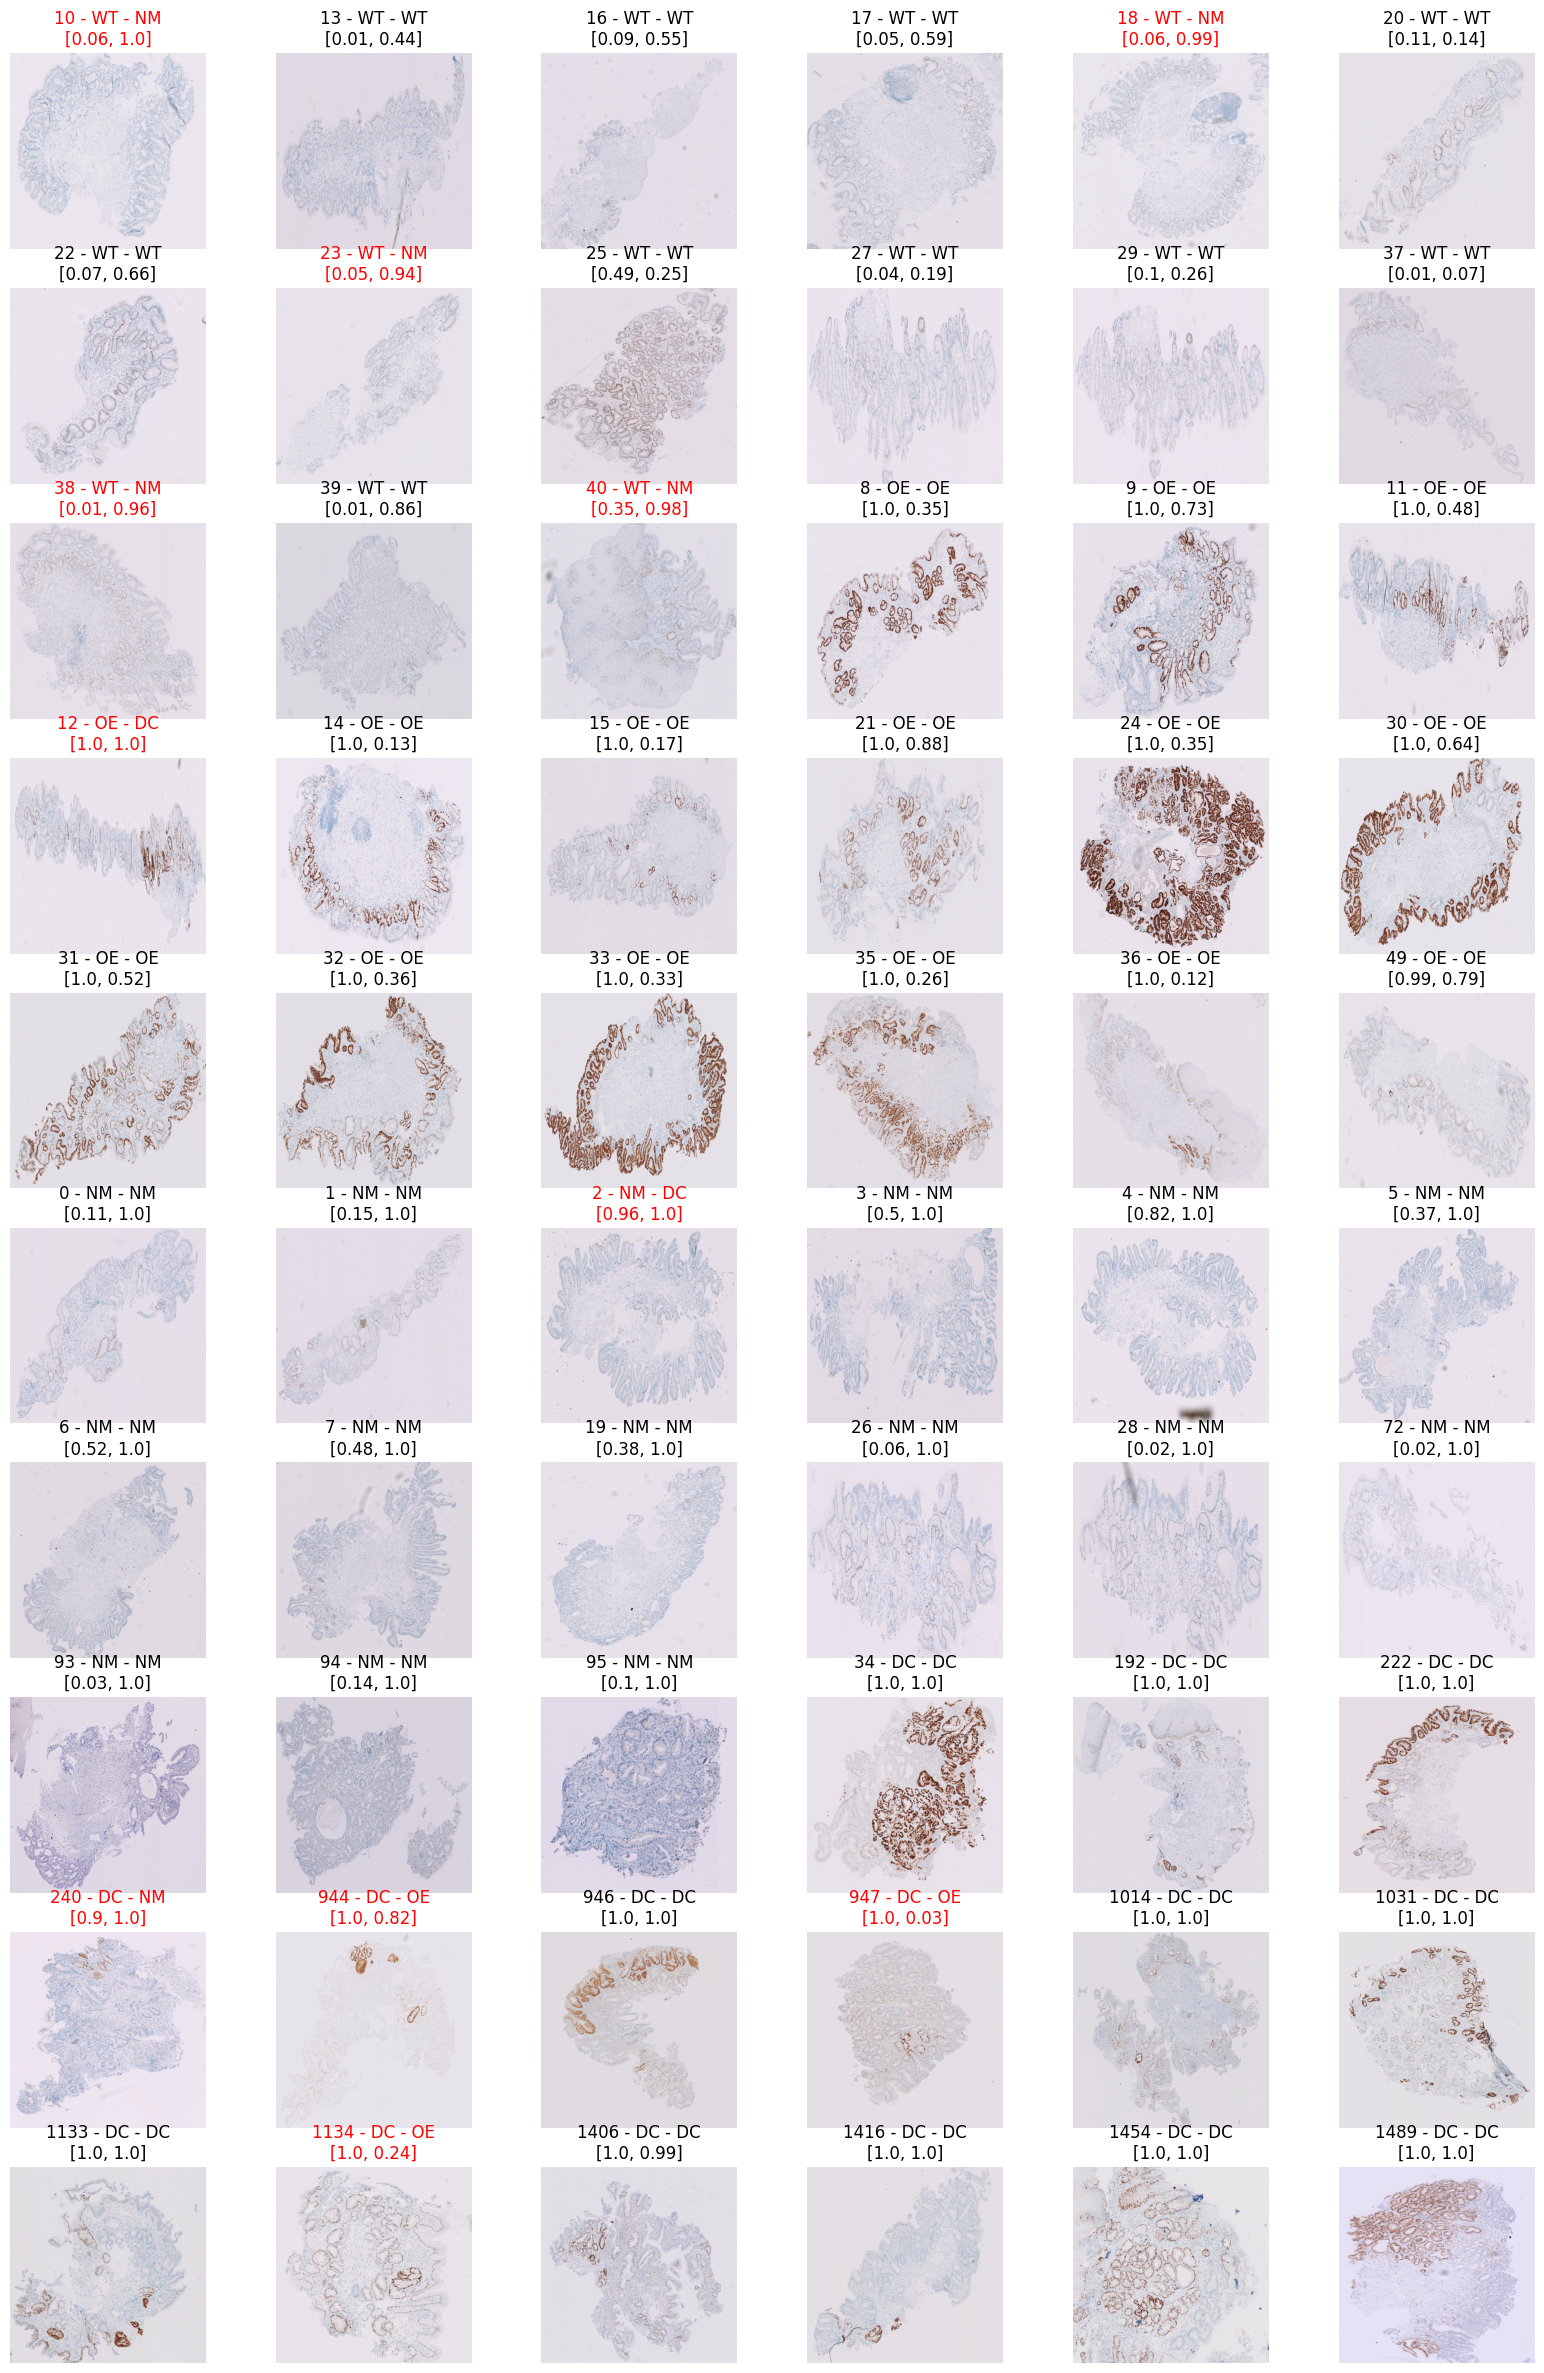

In [8]:
# Plot 10x6 grid of test images
label_mapping = {0:"WT", 1:"OE", 2:"NM", 3:"DC"}
fig, axs = plt.subplots(10, 6, figsize=(20, 30))
mdl = model_patch
preds = []
labels = []
for i, (img, label) in enumerate(test_loader):
    img = img.squeeze().numpy()
    label = label.item()
    row = i // 6
    col = i % 6
    img = (img - img.min()) / (img.max() - img.min())
    axs[row, col].imshow(np.transpose(img, (1, 2, 0)))
    # class_probs = [round(e,2) for e in mdl.outputs['test'][i]['presence_probs'].tolist()]
    # pred = mdl.outputs['test'][i]['preds']
    # class_probs = mdl.outputs['test'][i]['patch_scores'].max(dim=0)[0].tolist()

    sorted_oe_patch_scores = sorted(mdl.outputs['test'][i]['patch_scores'][:,0].tolist(), reverse=True)
    sorted_nm_patch_scores = sorted(mdl.outputs['test'][i]['patch_scores'][:,1].tolist(), reverse=True)
    class_probs = [np.mean(sorted_oe_patch_scores[:1]), np.mean(sorted_nm_patch_scores[:1])]

    pred = 1*(class_probs[0] > 0.9) + 2*(class_probs[1] > 0.9)
    label = mdl.outputs['test'][i]['labels']
    if type(pred) == torch.Tensor:
        pred = pred.item()
    if type(label) == torch.Tensor:
        label = label.item()
    preds.append(pred)
    labels.append(label)
    biop_idx = test_dataset.labels[i][0]
    title = f"{biop_idx} - {label_mapping[label]} - {label_mapping[pred]}\n{[round(e,2) for e in class_probs]}"
    axs[row, col].set_title(title)
    axs[row, col].axis("off")

    # Make title red if the prediction is wrong
    if pred != label:
        axs[row, col].set_title(title, color="red")

print("Accuracy: ", np.mean([1 if p == l else 0 for p, l in zip(preds, labels)]))
plt.show()

# CONFUSION MATRICES

In [10]:
def plot_confusion_matrix(confusion_matrix, class_names=P53_CLASS_NAMES):
    # Plot confusion matrix
    fig, ax = plt.subplots()
    cax = ax.matshow(confusion_matrix.cpu().numpy())
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names, rotation=45)
    ax.set_yticklabels(class_names, rotation=45)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    # Put the number in each cell with two decimal points
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            # Normalized number
            num = confusion_matrix[i, j].item() / confusion_matrix[i, :].sum().item()
            color = "w"
            if num > 0.7:
                color = "b"
            plt.text(j, i, f"{num:.2f}", ha='center', va='center', color=color)
    plt.show()

def calculate_metrics(confusion_matrix):
    accuracy = confusion_matrix.diag().sum().item() / confusion_matrix.sum().item()
    sensitivity = confusion_matrix[1, 1].item() / confusion_matrix[1, :].sum().item()
    specificity = confusion_matrix[0, 0].item() / confusion_matrix[0, :].sum().item()
    return accuracy, sensitivity, specificity

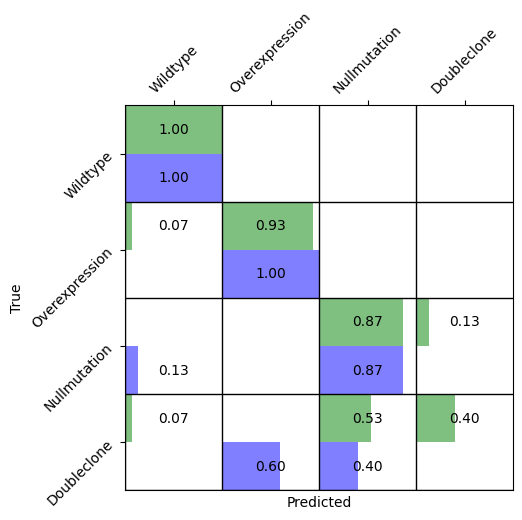

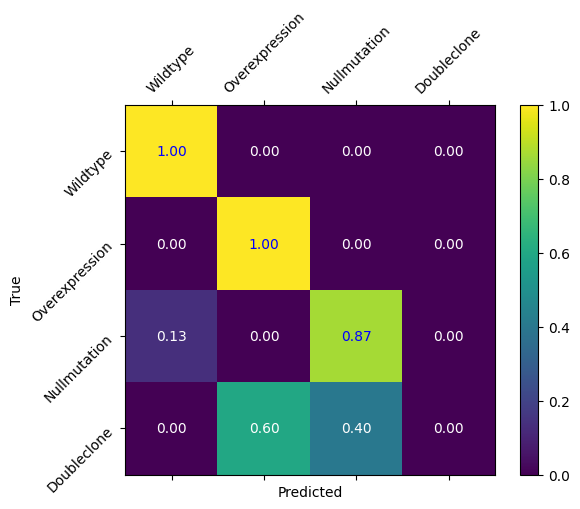

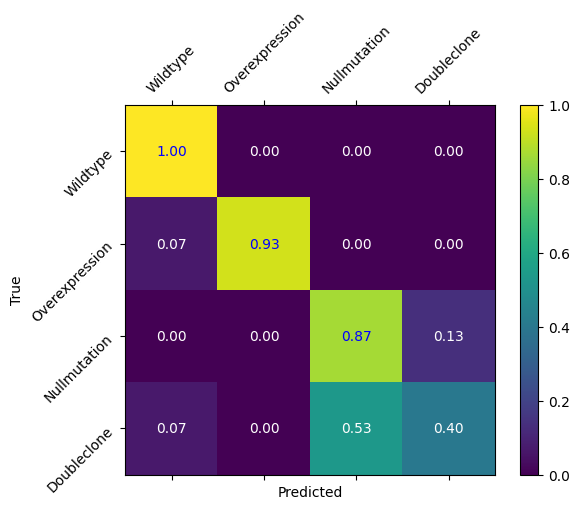

Binary confusion matrix:
tensor([[1.0000, 0.0000],
        [0.0444, 0.9556]])


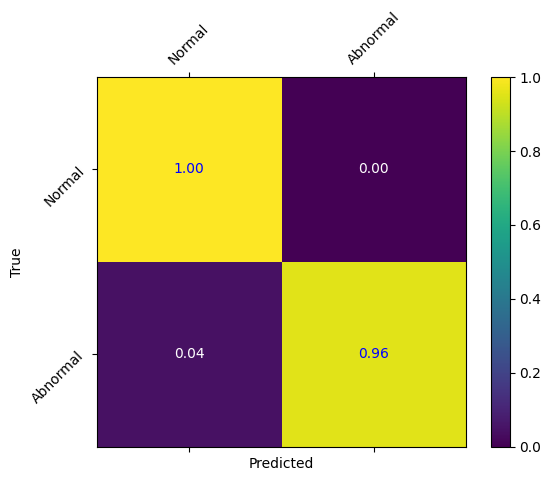

Accuracy: 0.97
Sensitivity: 0.96
Specificity: 1.00


In [53]:
confusion_matrix1 = torch.tensor([
    [15,0,0,0],
    [0,15,0,0],
    [2,0,13,0],
    [0,9,6,0],
]) /15 # for 1024 multiclass

confusion_matrix2 = torch.tensor([
    [15,0,0,0],
    [1,14,0,0],
    [0,0,13,2],
    [1,0,8,6]
]) / 15 # For 1024 double binary 50 epochs (double binary)


def plot_multi_confusion_matrix(confusion_matrices, class_names=P53_CLASS_NAMES):
    """Instead of colouring the cell for intensity, plot multiple bars for each cell.
    Each bar corresponds to a different confusion matrix, and has a corresponding color.
    Each cell of the confusion matrix is a subplot with multiple bars."""
    fig, ax = plt.subplots(len(class_names), len(class_names), figsize=(8, 8))
    width = 1
    # Assign colors to each confusion matrix
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            for k in range(len(confusion_matrices)):
                # Horizontal bar
                ax[i, j].barh(k, confusion_matrices[k][i, j].item(), width, color=colors[k], alpha=0.5)
                ax[i, j].set_xlim(0, 1)
                # ax[i, j].set_ylim(0, 1)
                ax[i, j].set_xticks([])
                ax[i, j].set_yticks([])
                ax[i, j].set_facecolor('w')
                if i == 0:
                    ax[i, j].set_title(class_names[j])
                if j == 0:
                    ax[i, j].set_ylabel(class_names[i])
    plt.show()

def plot_multi_confusion_matrix_single_axis(confusion_matrices, class_names=P53_CLASS_NAMES):
    """Instead of colouring the cell for intensity, plot multiple bars for each cell.
    Each bar corresponds to a different confusion matrix, and has a corresponding color.
    Now there is only one subplot, and each bar is aligned to where the cell would be."""
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    # Assign colors to each confusion matrix
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    width = 1/len(confusion_matrices)

    # Place grid lines at the cell boundaries
    for i in range(len(class_names)):
        ax.axhline(i, color='k', linewidth=1)
        ax.axvline(i, color='k', linewidth=1)
    ax.set_xticks(np.arange(len(class_names))+0.5)
    ax.set_yticks(np.arange(len(class_names))+0.5)
    ax.set_xticklabels(class_names, rotation=45)
    ax.set_yticklabels(reversed(class_names), rotation=45)
    ax.set_xlim(0, len(class_names))
    ax.set_ylim(0, len(class_names))
    # Place x ticks above the plot
    ax.xaxis.tick_top()
    plt.xlabel('Predicted')
    plt.ylabel('True')

    for i in range(len(class_names)):
        for j in range(len(class_names)):
            cell_x = j
            cell_y = width/2 + len(class_names)-1-i
            for k in range(len(confusion_matrices)):
                bar_y = cell_y + width * k
                # Plot rectangle as horizontal bar
                ax.barh(bar_y, confusion_matrices[k][i, j].item(), width, left=cell_x, color=colors[k], alpha=0.5)
                # Put the number in the center of the bar
                num = confusion_matrices[k][i, j].item()
                if num > 0:
                    color = "black"
                    ax.text(cell_x + 0.5, bar_y, f"{num:.2f}", ha='center', va='center', color=color)
    plt.show()


# plot_multi_confusion_matrix([confusion_matrix1, confusion_matrix2])
plot_multi_confusion_matrix_single_axis([confusion_matrix1, confusion_matrix2])

plot_confusion_matrix(confusion_matrix1)
plot_confusion_matrix(confusion_matrix2)
confusion_matrix = confusion_matrix2

# Group by normal vs abnormal (where the 0 class is normal and the rest are abnormal)
confusion_matrix_binary = torch.zeros(2, 2)
confusion_matrix_binary[0, 0] = confusion_matrix[0, 0]
confusion_matrix_binary[0, 1] = confusion_matrix[0, 1:].sum()
confusion_matrix_binary[1, 0] = confusion_matrix[1:, 0].sum()
confusion_matrix_binary[1, 1] = confusion_matrix[1:, 1:].sum()
accuracy, sensitivity, specificity = calculate_metrics(confusion_matrix_binary)
confusion_matrix_binary[0, :] /= confusion_matrix_binary[0, :].sum()
confusion_matrix_binary[1, :] /= confusion_matrix_binary[1, :].sum()
print("Binary confusion matrix:")
print(confusion_matrix_binary)
plot_confusion_matrix(confusion_matrix_binary, class_names=["Normal", "Abnormal"])

# Print the overall accuracy, sensitivity, and specificity
print("Accuracy: {:.2f}".format(accuracy))
print("Sensitivity: {:.2f}".format(sensitivity))
print("Specificity: {:.2f}".format(specificity)
)

In [ ]:
# # Load results from clam
# import pandas as pd
# results = pd.read_csv("../CLAM/eval_results/EVAL_None/fold_0.csv")

# """ format:
# 	slide_id	Y	Y_hat	p_0	p_1	p_2
# 0	slide_0	2.0	2.0	5.078263e-05	0.000002	9.999471e-01
# 1	slide_1	2.0	2.0	1.980806e-04	0.000021	9.997807e-01
# """

# # Make the confusion matrix
# confusion_matrix = torch.zeros(4, 4)
# for i, row in results.iterrows():
#     true = int(row["Y"])
#     pred = int(row["Y_hat"])
#     confusion_matrix[true, pred] += 1

# plot_confusion_matrix(confusion_matrix)
# import json
# with open("../CLAM/results/test_s1/clam_preds.json", "r") as f:
#     clam_preds = json.load(f)

clam_preds = model_patch.outputs['test']

"""format:
[
    {preds: 0, labels: 0},
]
"""
# Make the confusion matrix
confusion_matrix = torch.zeros(4, 4)
for pred in clam_preds:
    true = int(pred["labels"])
    pred = int(pred["preds"])
    confusion_matrix[true, pred] += 1

print("Accuracy: ", confusion_matrix.diag().sum().item() / confusion_matrix.sum().item())
plot_confusion_matrix(confusion_matrix)

# Group by normal vs abnormal (where the 0 class is normal and the rest are abnormal)
confusion_matrix_binary = torch.zeros(2, 2)
confusion_matrix_binary[0, 0] = confusion_matrix[0, 0]
confusion_matrix_binary[0, 1] = confusion_matrix[0, 1:].sum()
confusion_matrix_binary[1, 0] = confusion_matrix[1:, 0].sum()
confusion_matrix_binary[1, 1] = confusion_matrix[1:, 1:].sum()
accuracy, sensitivity, specificity = calculate_metrics(confusion_matrix_binary)
confusion_matrix_binary[0, :] /= confusion_matrix_binary[0, :].sum()
confusion_matrix_binary[1, :] /= confusion_matrix_binary[1, :].sum()

print("Binary confusion matrix:")
print(confusion_matrix_binary)
plot_confusion_matrix(confusion_matrix_binary, class_names=["Normal", "Abnormal"])

# Print the overall accuracy, sensitivity, and specificity
print("Accuracy: {:.2f}".format(accuracy))
print("Sensitivity: {:.2f}".format(sensitivity))
print("Specificity: {:.2f}".format(specificity)
)

In [ ]:
for mdl in [
    model, 
    model_db, 
    # model_ks
    model_patch
    ]:
    outputs = mdl.outputs["test"]

    preds = torch.cat([x['preds'] for x in outputs])
    labels = torch.cat([x['labels'] for x in outputs])
    accuracy_per_class, confusion_matrix = mdl.get_accuracy_per_class(preds, labels)
    avg_accuracy = torch.mean(accuracy_per_class)

    print("Model: ", mdl.__class__.__name__)
    print("Average accuracy: ", avg_accuracy)

    display(confusion_matrix)
    plot_confusion_matrix(confusion_matrix)

In [ ]:
# Test the model on a random image from the dataset and display the result
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)
for i, (images, labels) in enumerate(test_loader):
    show_img = images[0].permute(1, 2, 0)
    # Move tensors to the configured device
    images = images.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    print("Predicted: ", P53_CLASS_NAMES[predicted.item()])
    print("Ground truth: ", P53_CLASS_NAMES[labels.item()])

    output_db = model_db(images) # Shape: (batch_size, 2)
    print("\nDouble binary output:")
    print(f"Overexpression: {output_db[0][0].item():.2f}")
    print(f"Nullmutation: {output_db[0][1].item():.2f}")

    # normalize the image between 0 and 1
    show_img = (show_img - show_img.min()) / (show_img.max() - show_img.min())
    plt.imshow(show_img)
    plt.show()
    break

# Test Receptive Field

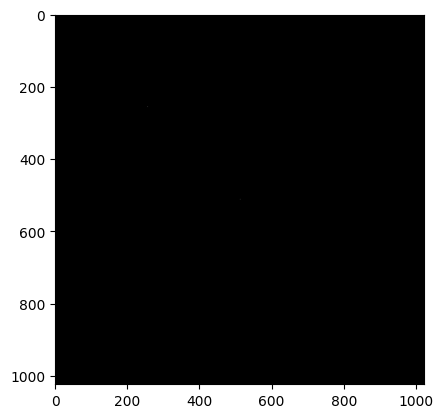

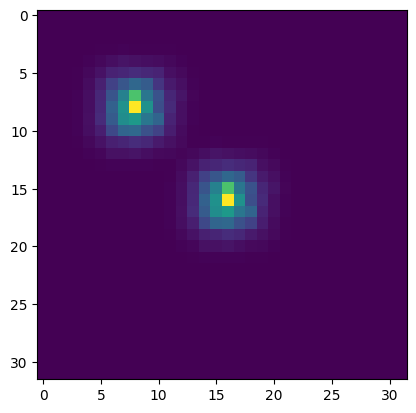

In [96]:
# Visualize how large ResNet18s receptive field is for different image sizes
from resnet import ResNetModel
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt

# Create a dummy input image
img_size = 1024
img = torch.zeros(1, 3, img_size, img_size)
img[:, :, img_size//2, img_size//2] = 1
img[:, :, img_size//4, img_size//4] = 1
# img[:, :, img_size//4:3*img_size//4, img_size//4:3*img_size//4] = 1

plt.imshow(img.squeeze().numpy().transpose(1, 2, 0))
plt.show()

# Load the model
model = models.resnet18()
# Set all parameters to 1
# for param in model.parameters():
#     param.data.fill_(1)
# Cut off before the pooling layer
# model = nn.Sequential(*list(list(model.children())[0].children())[:-2])
model = nn.Sequential(*list(model.children())[:-2])
# display(model)
model.eval()

# Get the output of the model
with torch.no_grad():
    output = model(img)

# Plot the output
output = output.squeeze().numpy().transpose(1, 2, 0).max(axis=2)
# display(output)
plt.imshow(output)
plt.show()

# CAM and GradCAM

In [ ]:
# Visualize gradient-based class activation maps (Grad-CAM)
#
# Grad-CAM is a technique to visualize the regions of the image that are important for the model's
# prediction. It does this by computing the gradients of the output class with respect to the
# feature maps of the last convolutional layer of the model. The gradients are then used to compute
# a weighted sum of the feature maps, where the weights are the gradients. The resulting heatmap
# is then overlaid on the original image to visualize the important regions.
#
# The code below is adapted from the PyTorch Grad-CAM tutorial:
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#grad-cam
def get_last_conv_layer(model):
    for name, layer in reversed(list(model.named_modules())):
        if isinstance(layer, torch.nn.Conv2d):
            return name, layer
    raise ValueError("No convolutional layer found in the model")

class GradCam:
    def __init__(self, model, target_layer, target_layer_name):
        self.model = model
        self.target_layer = target_layer
        self.target_layer_name = target_layer_name
        self.model.eval()
        self.feature_grad = None
        self.feature_map = None
        self.hook_feature_map()
        self.hook_feature_grad()

    def hook_feature_map(self):
        def hook_fn(module, input, output):
            self.feature_map = output
        self.target_layer.register_forward_hook(hook_fn)

    def hook_feature_grad(self):
        def hook_fn(module, grad_input, grad_output):
            self.feature_grad = grad_output[0]
        self.target_layer.register_backward_hook(hook_fn)

    def forward(self, x):
        return self.model(x)

    def backward(self, output, target_class):
        self.model.zero_grad()
        one_hot_output = torch.zeros((1, output.size()[-1]), dtype=torch.float32, device=output.device)
        one_hot_output[0][target_class] = 1
        output.backward(gradient=one_hot_output, retain_graph=True)

    def __call__(self, x, target_class, img_size):
        output = self.forward(x)
        self.backward(output, target_class)
        if self.feature_grad is None or self.feature_map is None:
            raise ValueError("Feature gradients or feature maps are not set. Check hooks.")
        
        weights = torch.mean(self.feature_grad, dim=(2, 3)).squeeze()
        cam = torch.tensordot(weights, self.feature_map.squeeze(0), dims=([0], [0]))
        cam = torch.nn.functional.relu(cam)
        
        # Avoid NaNs in normalization
        if torch.isnan(cam).any():
            raise ValueError("CAM contains NaN values before normalization.")
        
        cam = torch.nn.functional.interpolate(cam.unsqueeze(0).unsqueeze(0), size=(img_size, img_size), mode='bilinear', align_corners=False)
        cam = cam.squeeze(0).squeeze(0)
        
        cam_min, cam_max = cam.min(), cam.max()
        cam = (cam - cam_min)
        if cam_max == cam_min:
            print("CAM has uniform values. Check model and target class.")
        else:
            cam /= (cam_max - cam_min)
        
        return cam

def get_grad_cam(model, img, target_class, img_size):
    model.eval()
    last_conv_layer_name, last_conv_layer = get_last_conv_layer(model)
    grad_cam = GradCam(model, last_conv_layer, last_conv_layer_name)
    return grad_cam(img, target_class, img_size)

    
# Visualize the Grad-CAM heatmap for the predicted class
# Doubleclone idx: 56, 46, 53, 54
idx = np.random.randint(len(test_dataset))
idx = 19
print("Image index: ", idx)
img, label = test_dataset[idx]
img_size = img.size(-1)
show_img = img.permute(1, 2, 0)
img = img.unsqueeze(0).to(device)
outputs = model(img)
_, predicted = torch.max(outputs, 1)
print("Predicted: ", predicted.item())
grad_cam_class1 = get_grad_cam(model, img, 1, img_size).cpu().detach().numpy().squeeze()
grad_cam_class2 = get_grad_cam(model, img, 2, img_size).cpu().detach().numpy().squeeze()

# Normalize the img
show_img = (show_img - show_img.min()) / (show_img.max() - show_img.min())

# Plot the original image and the Grad-CAM heatmap, and the original image with the heatmap overlayed
fig, ax = plt.subplots(1, 3, figsize=(30, 30))
ax[0].imshow(show_img)
ax[0].set_title("Original image\nLabel: {}\nPredicted: {}".format(P53_CLASS_NAMES[label], P53_CLASS_NAMES[predicted.item()]))
ax[1].imshow(show_img)
ax[1].imshow(grad_cam_class1, vmin=0, vmax=1, alpha=0.5, cmap='jet')
ax[1].set_title("Grad-CAM heatmap\nOverexpression")
ax[2].imshow(show_img)
ax[2].imshow(grad_cam_class2, vmin=0, vmax=1, alpha=0.5, cmap='jet')
ax[2].set_title("Grad-CAM heatmap\nNull mutation")
ax[0].axis("off")
ax[1].axis("off")
ax[2].axis("off")
plt.show()

In [ ]:
# Visualize Class Activation Mapping (CAM)
#
# CAM is a technique to visualize the regions of the image that are important for the model's
# prediction. It does this by computing the class activation map, which is a weighted sum of the
# feature maps of the last convolutional layer of the model. The weights are the learned weights of
# the last fully connected layer of the model. The resulting heatmap is then overlaid on the
# original image to visualize the important regions.
#

def get_cam(model, img, target_class):
    model.eval()
    last_conv_layer_name, last_conv_layer = get_last_conv_layer(model)
    cam = Cam(model, last_conv_layer, last_conv_layer_name)
    return cam(img, target_class)

class Cam:
    def __init__(self, model, target_layer, target_layer_name):
        self.model = model
        self.target_layer = target_layer
        self.target_layer_name = target_layer_name
        self.model.eval()
        self.feature_map = None
        self.hook_feature_map()
        self.weights = list(self.model.model.parameters())[-2]
        self.weights = self.weights.squeeze()

    def hook_feature_map(self):
        def hook_fn(module, input, output):
            self.feature_map = output
        self.target_layer.register_forward_hook(hook_fn)
    
    def __call__(self, x, target_class):
        output = self.model(x)
        cam = torch.tensordot(self.weights[target_class], self.feature_map, dims=([0], [1]))
        cam = torch.nn.functional.relu(cam)
        cam = torch.nn.functional.interpolate(cam.unsqueeze(0), size=(img_size, img_size), mode='bilinear', align_corners=False)
        cam = cam.squeeze(0)
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        return cam
    
# Visualize the CAM heatmap for the predicted class
# idx = np.random.randint(len(test_dataset))
idx = 59
print("Image index: ", idx)
img, label = test_dataset[idx]
show_img = img.permute(1, 2, 0)
img = img.unsqueeze(0).to(device)
outputs = model(img)
outputs = torch.nn.functional.softmax(outputs)
_, predicted = torch.max(outputs, 1)
print("Predicted: ", predicted.item())
cam_class1 = get_cam(model, img, 1).cpu().detach().numpy().squeeze()
cam_class2 = get_cam(model, img, 2).cpu().detach().numpy().squeeze()

# Normalize the img
show_img = (show_img - show_img.min()) / (show_img.max() - show_img.min())

# Plot the original image and the CAM heatmap, and the original image with the heatmap overlayed
fig, ax = plt.subplots(1, 3, figsize=(30, 30))
ax[0].imshow(show_img)
ax[0].set_title("Original image\nLabel: {}\nPredicted: {}".format(P53_CLASS_NAMES[label], P53_CLASS_NAMES[predicted.item()]))
ax[1].imshow(show_img)
ax[1].imshow(cam_class1, cmap='jet', vmin=0, vmax=1, alpha=0.5)
ax[1].set_title(f"CAM heatmap\nOverexpression [{outputs[0,1]:.2f}]")
ax[2].imshow(show_img)
ax[2].imshow(cam_class2, cmap='jet', vmin=0, vmax=1, alpha=0.5)
ax[2].set_title(f"CAM heatmap\nNull mutation [{outputs[0,2]:.2f}]")
ax[0].axis("off")
ax[1].axis("off")
ax[2].axis("off")
plt.show()

In [ ]:
# Visualize Class Activation Mapping (CAM) For Double Binary Model
#
# Keep in mind that in this case, we have a separate heatmap for the first and second binary classifier head
# The first heatmap will show the regions of the image that are important for the Overexpression prediction
# The second heatmap will show the regions of the image that are important for the Nullmutation prediction

# Visualize the CAM heatmap for the predicted class
idx = np.random.randint(len(test_dataset))
# idx = 19
print("Image index: ", idx)
img, label = test_dataset[idx]
img_size = img.size(-1)
show_img = img.permute(1, 2, 0)
img = img.unsqueeze(0).to(device)
outputs = model_db(img).cpu().detach().numpy().squeeze()
prediction = int(outputs[0] > 0.5) + 2 * int(outputs[1] > 0.5)
# In this case, the output is a tensor of shape (1, 2) with the independent predictions for each binary classifier
# Therefore we don't apply the argmax function to get the predicted class
print("Predicted: ", P53_CLASS_NAMES[prediction])
grad_cam_class1 = get_grad_cam(model_db, img, 0, img_size).cpu().detach().numpy().squeeze()
grad_cam_class2 = get_grad_cam(model_db, img, 1, img_size).cpu().detach().numpy().squeeze()
cam_class1 = get_cam(model_db, img, 0).cpu().detach().numpy().squeeze()
cam_class2 = get_cam(model_db, img, 1).cpu().detach().numpy().squeeze()

# Normalize the img
show_img = (show_img - show_img.min()) / (show_img.max() - show_img.min())

# Plot the original image and the grad-CAM and CAM heatmap
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax[0, 0].imshow(show_img)
ax[0, 0].set_title("Original image\nLabel: {}\nPredicted: {}".format(P53_CLASS_NAMES[label], P53_CLASS_NAMES[prediction]))
ax[0, 1].imshow(show_img)
ax[0, 1].imshow(grad_cam_class1, vmin=0, vmax=1, alpha=0.5, cmap='jet')
ax[0, 1].set_title(f"Grad-CAM heatmap\nOverexpression {outputs[0]:.2f}")
ax[0, 2].imshow(show_img)
ax[0, 2].imshow(grad_cam_class2, vmin=0, vmax=1, alpha=0.5, cmap='jet')
ax[0, 2].set_title(f"Grad-CAM heatmap\nNullmutation {outputs[1]:.2f}")
ax[1, 1].imshow(show_img)
ax[1, 1].imshow(cam_class1, cmap='jet', vmin=0, vmax=1, alpha=0.5)
ax[1, 1].set_title(f"CAM heatmap\nOverexpression {outputs[0]:.2f}")
ax[1, 2].imshow(show_img)
ax[1, 2].imshow(cam_class2, cmap='jet', vmin=0, vmax=1, alpha=0.5)
ax[1, 2].set_title(f"CAM heatmap\nNullmutation {outputs[1]:.2f}")
plt.show()

# Predicting Patches with Fullsize model

In [ ]:
idx = np.random.randint(len(test_dataset))
# idx = 54
print("Image index: ", idx)
img, label = test_dataset[idx]
img_size = img.shape[-1]
show_img = img.permute(1, 2, 0)

# # Split into a batch of images of size patch_size x patch_size
patch_size = 256
patches = img.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
patches = patches.contiguous().view(-1, 3, patch_size, patch_size)
patches = patches.to(device)

outputs = model_db(patches).cpu().detach().numpy() # Shape: (batch_size, 2)
output = outputs.max(axis=0) # (2,)
prediction = int(output[0] > 0.5) + 2 * int(output[1] > 0.5)
# In this case, the output is a tensor of shape (1, 2) with the independent predictions for each binary classifier
# Therefore we don't apply the argmax function to get the predicted class
print("Predicted: ", P53_CLASS_NAMES[prediction])

# Make heatmap as grid of patch outputs
overexpression_heatmap = np.zeros((img_size, img_size))
nullmutation_heatmap = np.zeros((img_size, img_size))

for i in range(patches.shape[0]):
    row = i // (img_size // patch_size)
    col = i % (img_size // patch_size)
    overexpression_heatmap[row*patch_size:(row+1)*patch_size, col*patch_size:(col+1)*patch_size] = outputs[i, 0]
    nullmutation_heatmap[row*patch_size:(row+1)*patch_size, col*patch_size:(col+1)*patch_size] = outputs[i, 1]

# Normalize the img
show_img = (show_img - show_img.min()) / (show_img.max() - show_img.min())

# Plot the original image and the heatmap
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(show_img)
ax[0].set_title("Original image\nLabel: {}\nPredicted: {}".format(P53_CLASS_NAMES[label], P53_CLASS_NAMES[prediction]))
ax[1].imshow(show_img)
ax[1].imshow(overexpression_heatmap, vmin=0, vmax=1, alpha=0.5, cmap='jet')
ax[1].set_title(f"heatmap\nOverexpression {output[0]:.2f}")
ax[2].imshow(show_img)
ax[2].imshow(nullmutation_heatmap, vmin=0, vmax=1, alpha=0.5, cmap='jet')
ax[2].set_title(f"heatmap\nNullmutation {output[1]:.2f}")

# Put text on the heatmaps with the prediction for each patch
for i in range(patches.shape[0]):
    row = i // (img_size // patch_size)
    col = i % (img_size // patch_size)
    ax[1].text(col*patch_size + patch_size//2, row*patch_size + patch_size//2, f"{outputs[i, 0]:.2f}", ha='center', va='center', color='w')
    ax[2].text(col*patch_size + patch_size//2, row*patch_size + patch_size//2, f"{outputs[i, 1]:.2f}", ha='center', va='center', color='w')

plt.show()

# Blacking out Patches with Fullsize model
to see which patches are most important

In [ ]:
idx = np.random.randint(len(test_dataset)-15) + 15
# idx = 27
print("Image index: ", idx)
img, label = test_dataset[idx]
img_mean_3ch = img.mean(dim=(1, 2))
img_size = img.shape[-1]
show_img = img.permute(1, 2, 0)

# Get base model prediction
img = img.unsqueeze(0).to(device)
with torch.no_grad():
    base_outputs = model_db(img).cpu().detach().numpy().squeeze()
base_prediction = int(base_outputs[0] > 0.5) + 2 * int(base_outputs[1] > 0.5)
print("Predicted scores: ", base_outputs)
print("Predicted: ", P53_CLASS_NAMES[base_prediction])
print("Ground truth: ", P53_CLASS_NAMES[label])

# Do the same as above but this time with overlap between the patches, to make the heatmap smoother
# So for example with patch size 256, but step size 64, we will have 16 times more patches
patch_size = 512
step_size = 128

# Pad the image to accommodate the step size when sliding the patches
pad = (patch_size - step_size)
img = torch.nn.functional.pad(img, (pad, 0, pad, 0)) # the order is left, right, top, bottom
img_size = img.shape[-1]

patches_removed = img.unsqueeze(0).clone() # Shape: (1, 3, img_size, img_size)
patches_removed = patches_removed.repeat(img_size // step_size, img_size // step_size, 1, 1, 1)
for i in range(0, img_size, step_size):
    for j in range(0, img_size, step_size):
        # patches_removed[i // step_size, j // step_size, :, i:i+patch_size, j:j+patch_size] = 0

        # Replace the patch with the mean of the image
        patches_removed[i // step_size, j // step_size, 0, i:i+patch_size, j:j+patch_size] = img_mean_3ch[0]
        patches_removed[i // step_size, j // step_size, 1, i:i+patch_size, j:j+patch_size] = img_mean_3ch[1]
        patches_removed[i // step_size, j // step_size, 2, i:i+patch_size, j:j+patch_size] = img_mean_3ch[2]

# Reshape the tensor to (B, 3, img_size, img_size)
patches_removed = patches_removed.view(-1, 3, img_size, img_size)

# Crop to the original image size
patches_removed = patches_removed[:, :, pad:, pad:]

# Get the model output for each image
outputs = torch.zeros(patches_removed.shape[0], 2)
for i in tqdm(range(patches_removed.shape[0])): # necessary for CUDA memory
    current_img = patches_removed[i].unsqueeze(0).to(device)
    with torch.no_grad():
        outputs[i] = model_db(current_img).cpu().detach().squeeze()
# Calculate the difference in the output for each image compared to the easy WildType image output
diff = base_outputs - outputs.numpy()
# Normalize the difference
diff = diff / 2 + 0.5

print(diff.max())

# Make heatmap as grid of patch outputs
overexpression_heatmap = np.zeros((img_size, img_size))
nullmutation_heatmap = np.zeros((img_size, img_size))

# Make a mask to keep track of the number of patches that overlap in each pixel
mask = np.zeros((img_size, img_size))

for i in range(diff.shape[0]):
    row = i // (img_size // step_size)
    col = i % (img_size // step_size)
    overexpression_heatmap[row*step_size:row*step_size+patch_size, col*step_size:col*step_size+patch_size] += diff[i, 0].item()
    nullmutation_heatmap  [row*step_size:row*step_size+patch_size, col*step_size:col*step_size+patch_size] += diff[i, 1].item()
    mask                  [row*step_size:row*step_size+patch_size, col*step_size:col*step_size+patch_size] += 1

# Crop to the original image size
overexpression_heatmap = overexpression_heatmap[pad:, pad:]
nullmutation_heatmap = nullmutation_heatmap[pad:, pad:]
mask = mask[pad:, pad:]

# Normalize the img by dividing by the mask
overexpression_heatmap /= mask
nullmutation_heatmap /= mask

# Add strong blur to the heatmap
overexpression_heatmap = cv2.GaussianBlur(overexpression_heatmap, (65, 65), 0)
nullmutation_heatmap = cv2.GaussianBlur(nullmutation_heatmap, (65, 65), 0)

# Normalize the img
show_img = (show_img - show_img.min()) / (show_img.max() - show_img.min())

# Plot the original image and the heatmap
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(show_img)
ax[0].set_title(f"Original image (idx:{idx},id:{test_dataset.labels[idx][0]})\nLabel: {P53_CLASS_NAMES[label]}\nPredicted: {P53_CLASS_NAMES[base_prediction]}")
ax[1].imshow(show_img)
ax[1].imshow(overexpression_heatmap, vmin=0, vmax=1, alpha=0.3, cmap='jet')
ax[1].set_title(f"heatmap\nOverexpression {base_outputs[0]:.2f}")
ax[2].imshow(show_img)
ax[2].imshow(nullmutation_heatmap, vmin=0, vmax=1, alpha=0.3, cmap='jet')
ax[2].set_title(f"heatmap\nNullmutation {base_outputs[1]:.2f}")
# ax[3].imshow(mask, vmin=0, vmax=16, cmap='gray')
# ax[3].set_title("Mask")

# Put text on the heatmaps with the prediction for each subpatch of step_size x step_size
# for i in range(diff.shape[0]):
#     row = i // (img_size // step_size)
#     col = i % (img_size // step_size)
#     oe_val = overexpression_heatmap[row*step_size, col*step_size]
#     nm_val = nullmutation_heatmap[row*step_size, col*step_size]
#     fontsize = 5
#     ax[1].text(col*step_size + step_size//2, row*step_size + step_size//2, f"{oe_val:.2f}", ha='center', va='center', color='w', fontsize=fontsize)
#     ax[2].text(col*step_size + step_size//2, row*step_size + step_size//2, f"{nm_val:.2f}", ha='center', va='center', color='w', fontsize=fontsize)

plt.show()

# Placing Patches in Easy WildType

In [ ]:
easy_wildtype = [i for i,x in enumerate(zip(model.outputs['test'], model_db.outputs['test'])) if x[0]['labels'] == 0 and x[0]['preds'] == 0 and x[1]['preds'] == 0]
print("Number of easy wildtype images: ", len(easy_wildtype))
idx = easy_wildtype[12] # 14 and 12 are good examples
print("Image index: ", idx)
print(model.outputs['test'][idx], model_db.outputs['test'][idx])
img, label = test_dataset[idx]
easy_WT_img = img

# Calculate output for the image
img = img.unsqueeze(0).to(device)
easy_WT_outputs = model(img).detach().cpu()
_, predicted = torch.max(easy_WT_outputs, 1)
print("Predicted: ", P53_CLASS_NAMES[predicted.item()])
print("Ground truth: ", P53_CLASS_NAMES[label])
easy_WT_output_db = model_db(img).detach().cpu() # Shape: (batch_size, 2)
print("\nDouble binary output:")
print(f"Overexpression: {easy_WT_output_db[0][0].item():.2f}")
print(f"Nullmutation: {easy_WT_output_db[0][1].item():.2f}")

show_img = img.cpu().squeeze().permute(1, 2, 0)
# Show the image
plt.imshow(show_img)
plt.show()

In [ ]:
def get_edge_pixels(img):
    """Return an array of pixels that are on the edge of the image"""
    edge_pixels = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if i == 0 or j == 0 or i == img.shape[0]-1 or j == img.shape[1]-1:
                edge_pixels.append(img[i, j])
    return np.array(edge_pixels)

In [ ]:
idx = np.random.randint(len(test_dataset)-15) + 15
idx = 45
print("Image index: ", idx)
img, label = test_dataset[idx]
show_img = img.permute(1, 2, 0)
edge_pixels = get_edge_pixels(img)

# Get base model prediction
img = img.unsqueeze(0).to(device)
with torch.no_grad():
    base_outputs = model_db(img).cpu().detach().numpy().squeeze()
base_prediction = int(base_outputs[0] > 0.5) + 2 * int(base_outputs[1] > 0.5)
print("Predicted scores: ", base_outputs)
print("Predicted: ", P53_CLASS_NAMES[base_prediction])
print("Ground truth: ", P53_CLASS_NAMES[label])

# Do the same as above but this time with overlap between the patches, to make the heatmap smoother
# So for example with patch size 256, but step size 64, we will have 16 times more patches
patch_size = 256
step_size = 128

# Pad the image to accommodate the step size when sliding the patches
# WT_img = easy_WT_img.clone()
# output_base = easy_WT_output_db.clone()
WT_img = torch.zeros_like(img).squeeze()
output_base = torch.zeros(2)
pad = (patch_size - step_size)
img = torch.nn.functional.pad(img, (pad, 0, pad, 0)) # the order is left, right, top, bottom
img_size = img.shape[-1]
# Fill with mean color of the image
pixels = img.squeeze().cpu()
# pixels = torch.tensor(edge_pixels)
WT_img[0] = pixels[0].mean()
WT_img[1] = pixels[1].mean()
WT_img[2] = pixels[2].mean()
WT_img = torch.nn.functional.pad(WT_img, (pad, 0, pad, 0), value=pixels.mean())

patches_added = WT_img.unsqueeze(0).clone() # Shape: (1, 3, img_size, img_size)
steps = img_size // step_size
patches_added = patches_added.repeat(steps, steps, 1, 1, 1)
for i in range(0, img_size, step_size):
    for j in range(0, img_size, step_size):
        # patches_added[i // step_size, j // step_size, :, i:i+patch_size, j:j+patch_size] = img[:, :, i:i+patch_size, j:j+patch_size]

        # Place patch in the middle of patches_added
        middle = img_size // 2 - patch_size // 2
        patch = img[:, :, i:i+patch_size, j:j+patch_size]
        w, h = patch.shape[-2], patch.shape[-1]
        patches_added[i // step_size, j // step_size, :, middle:middle+w, middle:middle+h] = img[:, :, i:i+patch_size, j:j+patch_size]

# Reshape the tensor to (B, 3, img_size, img_size)
patches_added = patches_added.view(-1, 3, img_size, img_size)

# Crop to the original image size
patches_added = patches_added[:, :, pad:, pad:]

# Get the model output for each image
outputs = torch.zeros(patches_added.shape[0], 2)
for i in tqdm(range(patches_added.shape[0])): # necessary for CUDA memory
    current_img = patches_added[i].unsqueeze(0).to(device)
    with torch.no_grad():
        outputs[i] = model_db(current_img).cpu().detach().squeeze()
# Calculate the difference in the output for each image compared to the easy WildType image output
diff = outputs - output_base
# Normalize the difference
diff[:, 0] = (diff[:, 0] - diff[:, 0].min())
diff[:, 1] = (diff[:, 1] - diff[:, 1].min())

# Make heatmap as grid of patch outputs
steps = img_size // step_size
overexpression_heatmap = np.zeros((steps, steps))
nullmutation_heatmap = np.zeros((steps, steps))

# Make a mask to keep track of the number of patches that overlap in each pixel
mask = np.zeros((steps, steps))

steps_per_patch = patch_size // step_size
for i in range(diff.shape[0]):
    row = i // (img_size // step_size)
    col = i % (img_size // step_size)
    overexpression_heatmap[row:row+steps_per_patch, col:col+steps_per_patch] += diff[i, 0].item()
    nullmutation_heatmap  [row:row+steps_per_patch, col:col+steps_per_patch] += diff[i, 1].item()
    mask                  [row:row+steps_per_patch, col:col+steps_per_patch] += 1

# Crop to the original image size
pad_steps = pad // step_size
overexpression_heatmap = overexpression_heatmap[pad_steps:, pad_steps:]
nullmutation_heatmap = nullmutation_heatmap[pad_steps:, pad_steps:]
mask = mask[pad_steps:, pad_steps:]

# Normalize the img by dividing by the mask
overexpression_heatmap /= mask
nullmutation_heatmap /= mask

# Resize the heatmap to the original image size
overexpression_heatmap = cv2.resize(overexpression_heatmap, (show_img.shape[1], show_img.shape[0]), 
                                    # interpolation=cv2.INTER_NEAREST
                                    )
nullmutation_heatmap = cv2.resize(nullmutation_heatmap, (show_img.shape[1], show_img.shape[0]), 
                                #   interpolation=cv2.INTER_NEAREST
                                  )

# Add strong blur to the heatmap
# overexpression_heatmap = cv2.GaussianBlur(overexpression_heatmap, (65, 65), 0)
# nullmutation_heatmap = cv2.GaussianBlur(nullmutation_heatmap, (65, 65), 0)

# Normalize the img
show_img = (show_img - show_img.min()) / (show_img.max() - show_img.min())

# Plot the original image and the heatmap
fig, ax = plt.subplots(1, 3, figsize=(30, 10))
ax[0].imshow(show_img)
ax[0].set_title(f"Original image (idx:{idx},id:{test_dataset.labels[idx][0]})\nLabel: {P53_CLASS_NAMES[label]}\nPredicted: {P53_CLASS_NAMES[base_prediction]}")
ax[1].imshow(show_img)
ax[1].imshow(overexpression_heatmap, vmin=0, vmax=1, alpha=0.3, cmap='jet')
ax[1].set_title(f"heatmap\nOverexpression {base_outputs[0]:.2f} max: {overexpression_heatmap.max():.2f}")
ax[2].imshow(show_img)
ax[2].imshow(nullmutation_heatmap, vmin=0, vmax=1, alpha=0.3, cmap='jet')
ax[2].set_title(f"heatmap\nNullmutation {base_outputs[1]:.2f} max: {nullmutation_heatmap.max():.2f}")

plt.show()

In [ ]:
display(edge_pixels)

In [ ]:
# Display patches_added
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
patch_added = patches_added[49].squeeze().permute(1, 2, 0)
patch_added = (patch_added - patch_added.min()) / (patch_added.max() - patch_added.min())
ax.imshow(patch_added)
plt.show()

# Keep-scale Heatmap

Image index:  45 34
Original image shape:  (2149, 2381, 3)
Predicted scores:  [1.         0.93958664]
Predicted:  Doubleclone
Ground truth:  Doubleclone


100%|██████████| 99/99 [00:00<00:00, 102.02it/s]


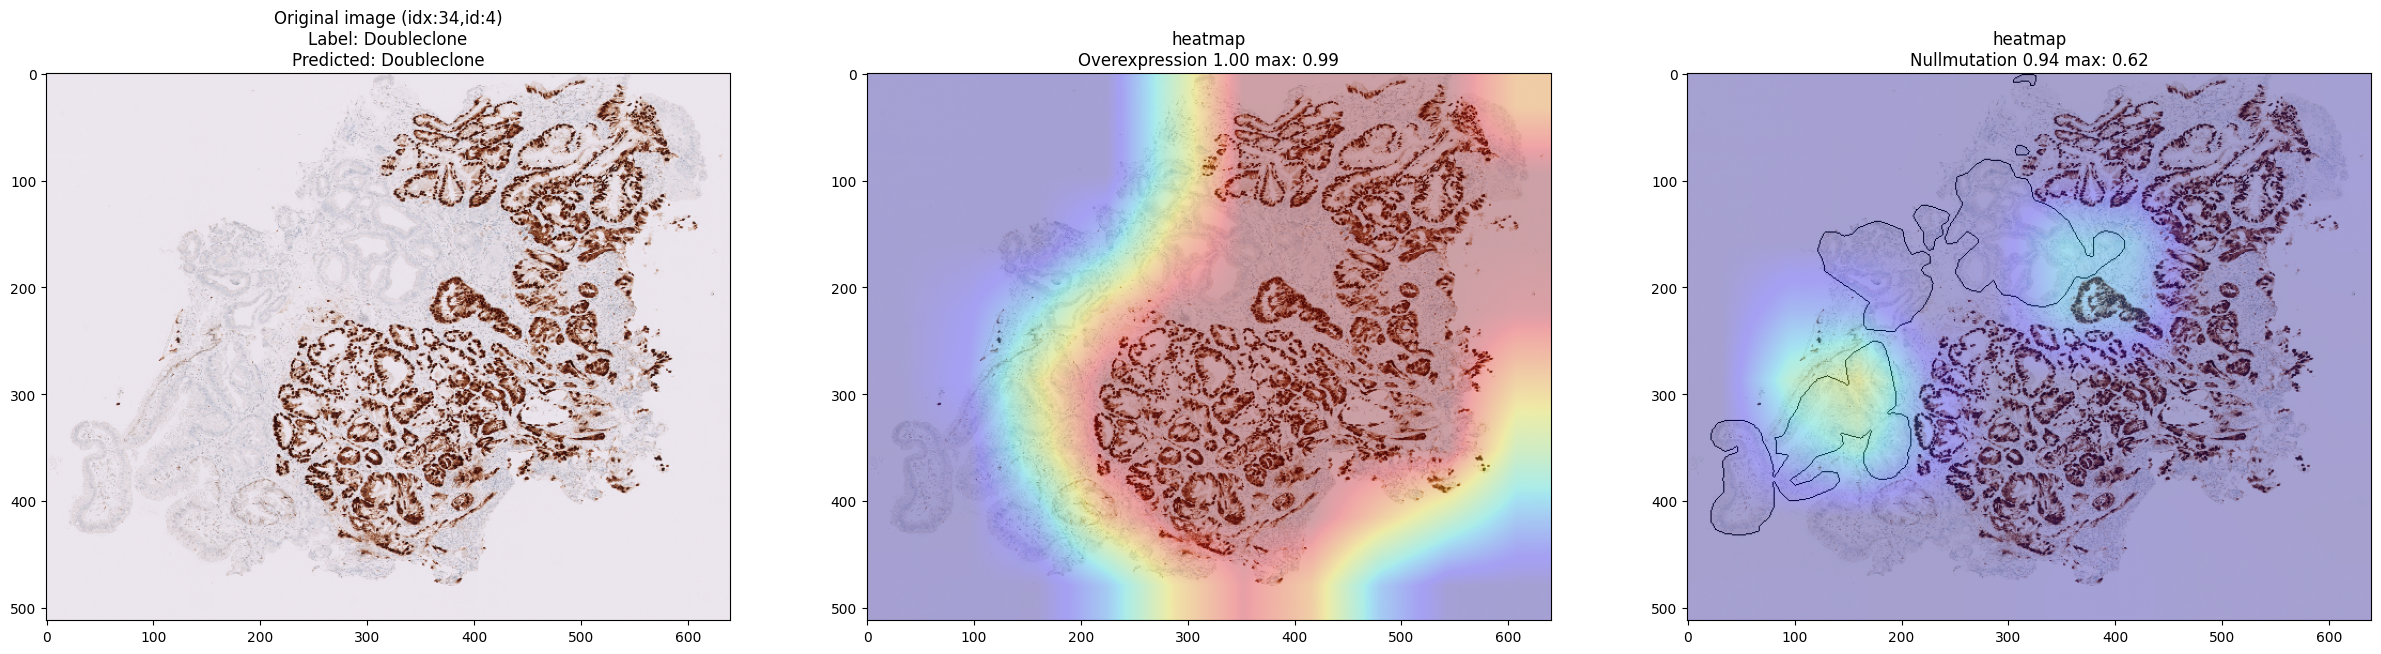

In [23]:
test_idx = np.random.randint(len(test_dataset)-15) + 15
test_idx = 45
idx = test_dataset.labels[test_idx][0]
print("Image index: ", test_idx, idx)
label = test_dataset.labels[test_idx][1]
img = plt.imread(os.path.join(DATA_DIR, "biopsies", f"{idx}.png")) # Shape: (h, w, 3)
h,w = img.shape[:2]
print("Original image shape: ", img.shape)

# With patch size 256, but step size 64, we will have 16 times more patches
patch_size = 128
step_size = 64

resize_factor = 0.25
h,w = h*resize_factor, w*resize_factor # downsample the image
h,w = round(h/patch_size)*patch_size, round(w/patch_size)*patch_size # make sure the image is divisible by the step size
img = cv2.resize(img, (w,h))

show_img = img
img = torch.tensor(img).permute(2, 0, 1).float()
if img.max() > 1:
    img /= 255

# Get base model prediction
img = TRANSFORMS["normalize"](img)
img = img.unsqueeze(0).to(device)
with torch.no_grad():
    base_outputs = model_ks(img).cpu().detach().numpy().squeeze()
base_prediction = int(base_outputs[0] > 0.5) + 2 * int(base_outputs[1] > 0.5)
print("Predicted scores: ", base_outputs)
print("Predicted: ", P53_CLASS_NAMES[base_prediction])
print("Ground truth: ", P53_CLASS_NAMES[label])


WT_img = torch.zeros_like(img).squeeze()
# Pad the image to accommodate the step size when sliding the patches
pad = (patch_size - step_size)
img = torch.nn.functional.pad(img, (pad, 0, pad, 0)) # the order is left, right, top, bottom
h_padded, w_padded = img.shape[-2], img.shape[-1]
# Fill with mean color of the image
pixels = img.squeeze().cpu()
WT_img[0] = pixels[0].mean()
WT_img[1] = pixels[1].mean()
WT_img[2] = pixels[2].mean()

# Place patches in the middle of the WT image
# patches_added = WT_img.unsqueeze(0).clone() # Shape: (1, 3, img_h, img_w)
# h_steps = h_padded // step_size
# w_steps = w_padded // step_size
# patches_added = patches_added.repeat(h_steps, w_steps, 1, 1, 1)
# for i in range(0, h_padded, step_size):
#     for j in range(0, w_padded, step_size):
#         # Place patch in the middle of patches_added
#         h_middle = WT_img.shape[-2] // 2 - patch_size // 2
#         w_middle = WT_img.shape[-1] // 2 - patch_size // 2
#         patch = img[:, :, i:i+patch_size, j:j+patch_size]
#         ph, pw = patch.shape[-2], patch.shape[-1]
#         patches_added[i // step_size, j // step_size, :, h_middle:h_middle+ph, w_middle:w_middle+pw] = img[:, :, i:i+patch_size, j:j+patch_size]
# # Reshape the tensor to (B, 3, img_size, img_size)
# patches_added = patches_added.view(-1, 3, WT_img.shape[-2], WT_img.shape[-1])

# Just have patches by themselves
h_steps = h_padded // step_size
w_steps = w_padded // step_size
patches_added = torch.zeros(h_steps, w_steps, 3, patch_size, patch_size)
for i in range(0, h_padded, step_size):
    for j in range(0, w_padded, step_size):
        # Place patch in the middle of patches_added
        patch = img[:, :, i:i+patch_size, j:j+patch_size]
        ph, pw = patch.shape[-2], patch.shape[-1]
        h_middle = patch_size // 2 - ph // 2
        w_middle = patch_size // 2 - pw // 2
        patches_added[i // step_size, j // step_size, :, h_middle:h_middle+ph, w_middle:w_middle+pw] = patch
# Reshape the tensor to (B, 3, img_size, img_size)
patches_added = patches_added.view(-1, 3, patch_size, patch_size)

# Get the model output for each image
diff = torch.zeros(patches_added.shape[0], 2)
for i in tqdm(range(patches_added.shape[0])): # necessary for CUDA memory
    current_img = patches_added[i].unsqueeze(0).to(device)
    with torch.no_grad():
        diff[i] = model_ks(current_img).cpu().detach().squeeze()
# Normalize the difference
diff[:, 0] = (diff[:, 0] - diff[:, 0].min())
diff[:, 1] = (diff[:, 1] - diff[:, 1].min())

# Make heatmap as grid of patch outputs
overexpression_heatmap = np.zeros((h_steps, w_steps))
nullmutation_heatmap = np.zeros((h_steps, w_steps))

# Make a mask to keep track of the number of patches that overlap in each pixel
mask = np.zeros((h_steps, w_steps))

steps_per_patch = patch_size // step_size
for i in range(diff.shape[0]):
    row = i // w_steps
    col = i % w_steps
    overexpression_heatmap[row:row+steps_per_patch, col:col+steps_per_patch] += diff[i, 0].item()
    nullmutation_heatmap  [row:row+steps_per_patch, col:col+steps_per_patch] += diff[i, 1].item()
    mask                  [row:row+steps_per_patch, col:col+steps_per_patch] += 1

# Crop to the original image size
pad_steps = pad // step_size
overexpression_heatmap = overexpression_heatmap[pad_steps:, pad_steps:]
nullmutation_heatmap = nullmutation_heatmap[pad_steps:, pad_steps:]
mask = mask[pad_steps:, pad_steps:]

# Normalize the img by dividing by the mask
overexpression_heatmap /= mask
nullmutation_heatmap /= mask

# Resize the heatmap to the original image size
overexpression_heatmap = cv2.resize(overexpression_heatmap, (show_img.shape[1], show_img.shape[0]), 
                                    # interpolation=cv2.INTER_NEAREST
                                    )
nullmutation_heatmap = cv2.resize(nullmutation_heatmap, (show_img.shape[1], show_img.shape[0]),
                                    # interpolation=cv2.INTER_NEAREST
                                    )


# Normalize the img
show_img = (show_img - show_img.min()) / (show_img.max() - show_img.min())

# Plot the original image and the heatmap
fig, ax = plt.subplots(1, 3, figsize=(30, 10))
ax[0].imshow(show_img)
ax[0].set_title(f"Original image (idx:{idx},id:{test_dataset.labels[test_idx][0]})\nLabel: {P53_CLASS_NAMES[label]}\nPredicted: {P53_CLASS_NAMES[base_prediction]}")
ax[1].imshow(show_img)
ax[1].imshow(overexpression_heatmap, vmin=0, vmax=1, alpha=0.3, cmap='jet')
ax[1].set_title(f"heatmap\nOverexpression {base_outputs[0]:.2f} max: {overexpression_heatmap.max():.2f}")

if label in [2,3]:
    mask = cv2.imread(os.path.join(DATA_DIR, "masks", f"{idx}.png"), cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (show_img.shape[1], show_img.shape[0]))
    contours = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Draw the contours on the image
    cv2.drawContours(show_img, contours[0], -1, (0, 0, 0), 1)

ax[2].imshow(show_img)
ax[2].imshow(nullmutation_heatmap, vmin=0, vmax=1, alpha=0.3, cmap='jet')
ax[2].set_title(f"heatmap\nNullmutation {base_outputs[1]:.2f} max: {nullmutation_heatmap.max():.2f}")

plt.show()

# Patch Classifier with overlap

Image index:  55 1134
Original image shape:  (2031, 1748, 3)


100%|██████████| 8/8 [00:00<00:00,  8.60it/s]


Predicted scores:  tensor([0.9582, 0.9012])
Predicted:  Doubleclone
Ground truth:  Doubleclone


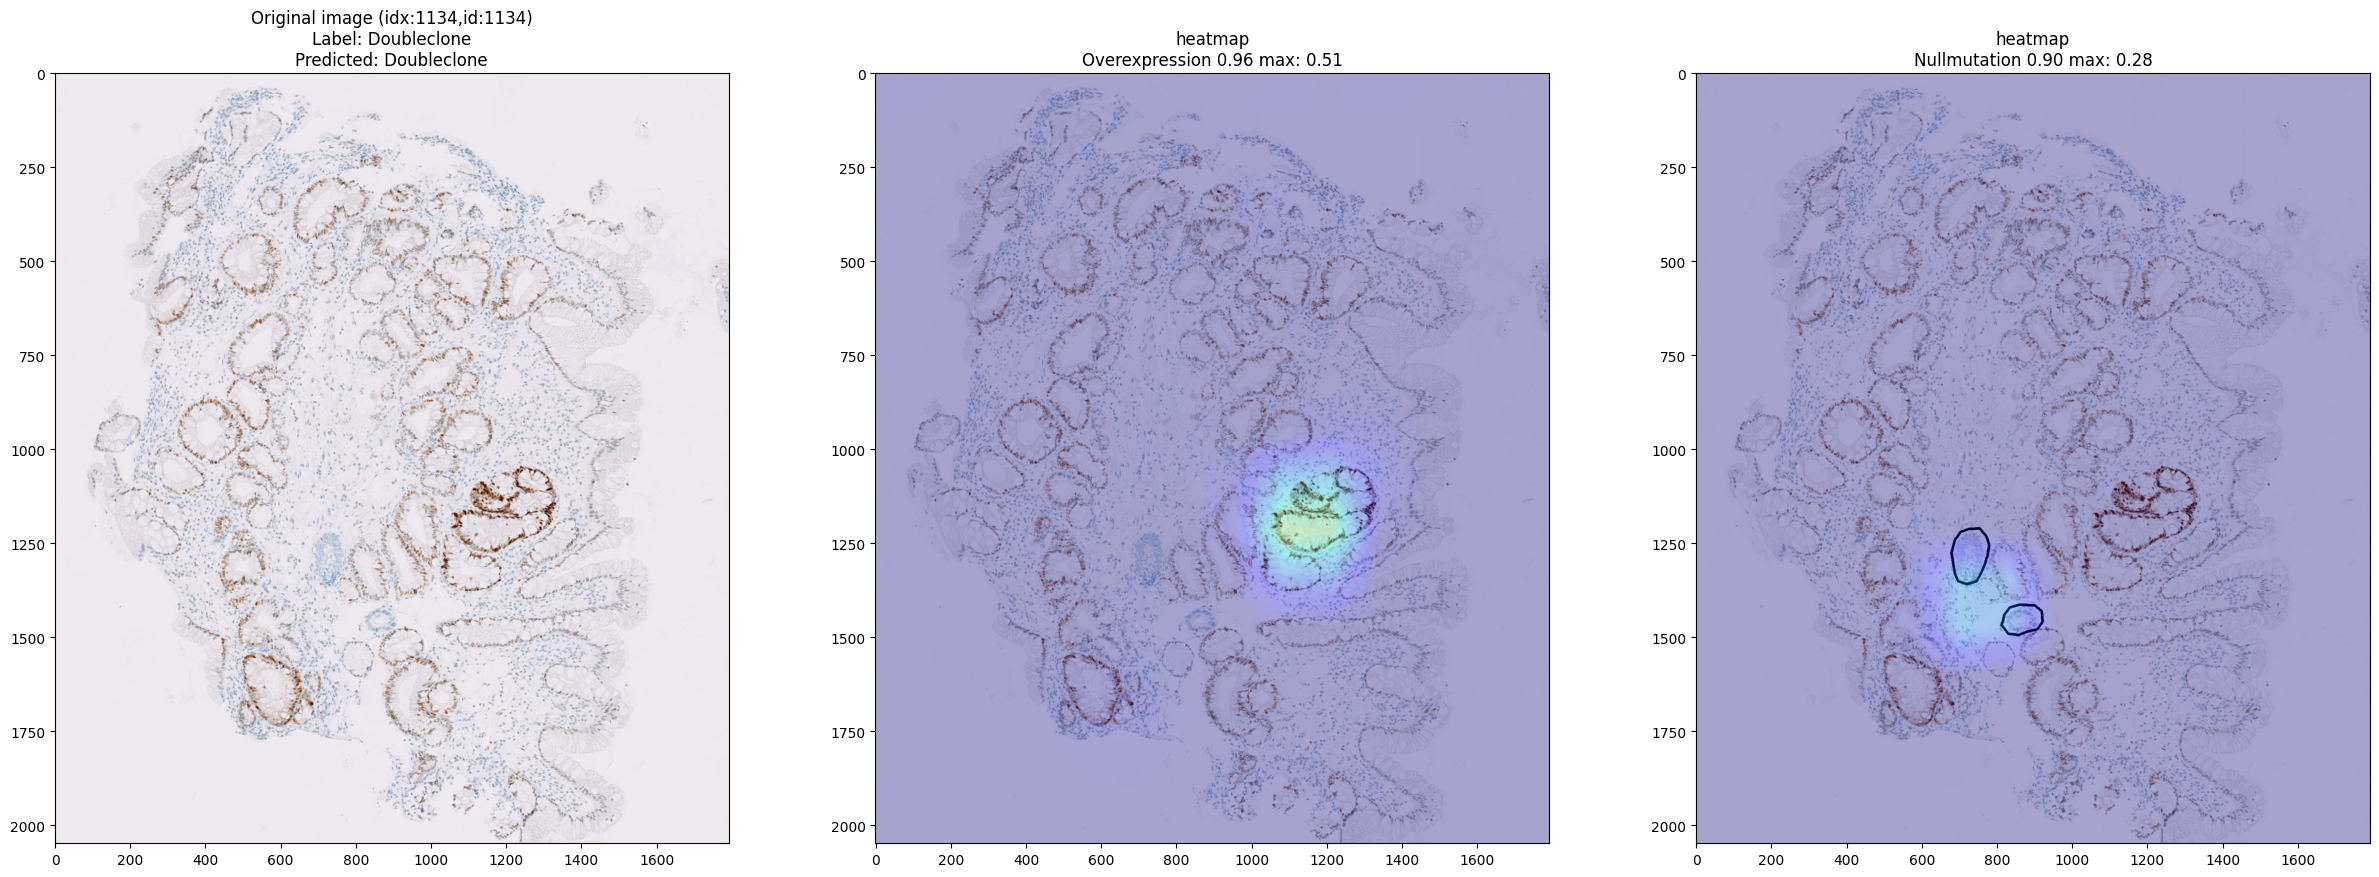

In [48]:
test_idx = np.random.randint(len(test_dataset)-15) + 15
test_idx = 55
idx = test_dataset.labels[test_idx][0]
print("Image index: ", test_idx, idx)
label = test_dataset.labels[test_idx][1]
img = plt.imread(os.path.join(DATA_DIR, "biopsies", f"{idx}.png")) # Shape: (h, w, 3)
h,w = img.shape[:2]
print("Original image shape: ", img.shape)

# With patch size 256, but step size 64, we will have 16 times more patches
patch_size = 256
step_size = 128

resize_factor = 1
h,w = h*resize_factor, w*resize_factor # downsample the image
h,w = round(h/patch_size)*patch_size, round(w/patch_size)*patch_size # make sure the image is divisible by the step size
img = cv2.resize(img, (w,h))

show_img = img
img = torch.tensor(img).permute(2, 0, 1).float()
if img.max() > 1:
    img /= 255

img = TRANSFORMS["normalize"](img)
img = img.unsqueeze(0).to(device)

# Pad the image to accommodate the step size when sliding the patches
pad = (patch_size - step_size)
img = torch.nn.functional.pad(img, (pad, 0, pad, 0)) # the order is left, right, top, bottom
h_padded, w_padded = img.shape[-2], img.shape[-1]

h_steps = h_padded // step_size
w_steps = w_padded // step_size
patches_added = torch.zeros(h_steps, w_steps, 3, patch_size, patch_size)
for i in range(0, h_padded, step_size):
    for j in range(0, w_padded, step_size):
        # Place patch in the middle of patches_added
        patch = img[:, :, i:i+patch_size, j:j+patch_size]
        ph, pw = patch.shape[-2], patch.shape[-1]
        h_middle = patch_size // 2 - ph // 2
        w_middle = patch_size // 2 - pw // 2
        patches_added[i // step_size, j // step_size, :, h_middle:h_middle+ph, w_middle:w_middle+pw] = patch
# Reshape the tensor to (B, 3, img_size, img_size)
patches_added = patches_added.view(-1, 3, patch_size, patch_size)

# Get the model output for each image
diff = torch.zeros(patches_added.shape[0], 2)
# Do this in batches of 10 patches
batch_size = 32
for i in tqdm(range(0, patches_added.shape[0], batch_size)): # necessary for CUDA memory
    current_patches = patches_added[i:i+batch_size].to(device)
    with torch.no_grad():
        patch_preds = model_patch(current_patches).cpu().detach().squeeze() # Shape: (batch_size, 2)
    diff[i:i+batch_size] = patch_preds
# Normalize the difference
diff[:, 0] = (diff[:, 0] - diff[:, 0].min())
diff[:, 1] = (diff[:, 1] - diff[:, 1].min())

biopsy_pred = diff.max(dim=0)[0] # Shape: (2)
biopsy_prediction = int(biopsy_pred[0] > 0.5) + 2 * int(biopsy_pred[1] > 0.5)

# Make heatmap as grid of patch outputs
overexpression_heatmap = np.zeros((h_steps, w_steps))
nullmutation_heatmap = np.zeros((h_steps, w_steps))

# Make a mask to keep track of the number of patches that overlap in each pixel
mask = np.zeros((h_steps, w_steps))

steps_per_patch = patch_size // step_size
for i in range(diff.shape[0]):
    row = i // w_steps
    col = i % w_steps
    overexpression_heatmap[row:row+steps_per_patch, col:col+steps_per_patch] += diff[i, 0].item()
    nullmutation_heatmap  [row:row+steps_per_patch, col:col+steps_per_patch] += diff[i, 1].item()
    mask                  [row:row+steps_per_patch, col:col+steps_per_patch] += 1

# Crop to the original image size
pad_steps = pad // step_size
overexpression_heatmap = overexpression_heatmap[pad_steps:, pad_steps:]
nullmutation_heatmap = nullmutation_heatmap[pad_steps:, pad_steps:]
mask = mask[pad_steps:, pad_steps:]

# Normalize the img by dividing by the mask
overexpression_heatmap /= mask
nullmutation_heatmap /= mask

# Resize the heatmap to the original image size
overexpression_heatmap = cv2.resize(overexpression_heatmap, (show_img.shape[1], show_img.shape[0]), 
                                    # interpolation=cv2.INTER_NEAREST
                                    )
nullmutation_heatmap = cv2.resize(nullmutation_heatmap, (show_img.shape[1], show_img.shape[0]),
                                    # interpolation=cv2.INTER_NEAREST
                                    )


print("Predicted scores: ", biopsy_pred)
print("Predicted: ", P53_CLASS_NAMES[biopsy_prediction])
print("Ground truth: ", P53_CLASS_NAMES[label])

# Normalize the img
show_img = (show_img - show_img.min()) / (show_img.max() - show_img.min())

# Plot the original image and the heatmap
fig, ax = plt.subplots(1, 3, figsize=(30, 10))
ax[0].imshow(show_img)
ax[0].set_title(f"Original image (idx:{idx},id:{test_dataset.labels[test_idx][0]})\nLabel: {P53_CLASS_NAMES[label]}\nPredicted: {P53_CLASS_NAMES[biopsy_prediction]}")
ax[1].imshow(show_img)
ax[1].imshow(overexpression_heatmap, vmin=0, vmax=1, alpha=0.3, cmap='jet')
ax[1].set_title(f"heatmap\nOverexpression {biopsy_pred[0]:.2f} max: {overexpression_heatmap.max():.2f}")

if label in [2,3]:
    mask = cv2.imread(os.path.join(DATA_DIR, "masks", f"{idx}.png"), cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (show_img.shape[1], show_img.shape[0]))
    contours = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Draw the contours on the image
    cv2.drawContours(show_img, contours[0], -1, (0, 0, 0), 5)

ax[2].imshow(show_img)
ax[2].imshow(nullmutation_heatmap, vmin=0, vmax=1, alpha=0.3, cmap='jet')
ax[2].set_title(f"heatmap\nNullmutation {biopsy_pred[1]:.2f} max: {nullmutation_heatmap.max():.2f}")

plt.show()

# Visualize test accuracies

In [ ]:
test_headers = """
Group: s2048_norm_e50 - accuracy/test	Group: s2048_norm_e50 - accuracy/test__MIN	Group: s2048_norm_e50 - accuracy/test__MAX	Group: s128_norm_e50 - accuracy/test	Group: s128_norm_e50 - accuracy/test__MIN	Group: s128_norm_e50 - accuracy/test__MAX	Group: s8_norm_e50 - accuracy/test	Group: s8_norm_e50 - accuracy/test__MIN	Group: s8_norm_e50 - accuracy/test__MAX	Group: s32_norm_e50 - accuracy/test	Group: s32_norm_e50 - accuracy/test__MIN	Group: s32_norm_e50 - accuracy/test__MAX	Group: s256_norm_e50 - accuracy/test	Group: s256_norm_e50 - accuracy/test__MIN	Group: s256_norm_e50 - accuracy/test__MAX	Group: s1024_norm_e50 - accuracy/test	Group: s1024_norm_e50 - accuracy/test__MIN	Group: s1024_norm_e50 - accuracy/test__MAX	Group: s64_norm_e50 - accuracy/test	Group: s64_norm_e50 - accuracy/test__MIN	Group: s64_norm_e50 - accuracy/test__MAX
"""
test_results = """
0.683333337306976	0.666666686534882	0.699999988079071	0.6	0.550000011920929	0.633333325386047	0.453333353996277	0.416666686534882	0.483333349227905	0.503333330154419	0.483333349227905	0.516666650772095	0.63333335518837	0.566666662693024	0.700000047683716	0.700000017881393	0.683333337306976	0.716666698455811	0.552083350718021	0.466666698455811	0.616666674613953
"""

# Parse test results
import re
import pandas
import numpy as np
from io import StringIO
from matplotlib import pyplot as plt

test_headers = re.sub(r"\t", ",", test_headers)
test_headers = re.sub(r"\n", "", test_headers)
test_results = re.sub(r"\t", ",", test_results)
test_results = re.sub(r"\n", ",", test_results)
test_results = re.sub(r",", "\n", test_results)
test_headers = re.sub(r"Group: ", "", test_headers)
test_headers = re.sub(r"_", "", test_headers)
test_headers = re.sub(r"norm", "", test_headers)
test_headers = re.sub(r"e50", "", test_headers)
test_headers = re.sub(r" - accuracy/test", "", test_headers)

# Make dataframe with headers and results
df = pandas.read_csv(StringIO(test_results), header=None)
df = df.T
df.columns = test_headers.split(",")
# Separate min and max into separate dataframes
min_df = df.filter(regex="MIN")
max_df = df.filter(regex="MAX")
df = df.drop(columns=min_df.columns)
df = df.drop(columns=max_df.columns)
# Remove MIN from column names
min_df.columns = min_df.columns.str.replace("MIN", "")
max_df.columns = max_df.columns.str.replace("MAX", "")

# Sort the columns in order of increasing image size
df = df[["s8", "s32", "s64", "s128", "s256", "s1024", "s2048"]]
min_df = min_df[["s8", "s32", "s64", "s128", "s256", "s1024", "s2048"]]
max_df = max_df[["s8", "s32", "s64", "s128", "s256", "s1024", "s2048"]]

display(df)
display(min_df)
display(max_df)

# Reshape error bars to 7,2,1
err = np.array([min_df.values, max_df.values]).transpose(2,0,1)
# xerr needs to be the difference, not the absolute value
err[:,0,0] = df.values - err[:,0,0]
err[:,1,0] = err[:,1,0] - df.values

# Plot the test results in a horizontal bar chart
# min and max df are displayed as a small black error bar
fig, ax = plt.subplots(
    figsize=(10, 5)
    )
df.plot(kind="barh", ax=ax, capsize=3, xerr=err, error_kw=dict(ecolor='k'))
plt.xlabel("Accuracy")
plt.ylabel("Model")
# Disable y ticks
plt.yticks([])
plt.title("Test accuracy per model")
plt.show()